# House Prices: Advanced Regression Techniques
## Predict sales prices and practice feature engineering, RFs, and gradient boosting
### Steps:
1. Preprocessing | Exploring | Random Weird SHit with the Data

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import graphlab 
graphlab.canvas.set_target('ipynb')
from scipy.stats import skew
from scipy.special import boxcox1p
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso, LassoCV

In [2]:
train=pd.read_csv("train.csv")
trainGl = graphlab.SFrame.read_csv('train.csv')
test=pd.read_csv("test.csv")
test2=pd.read_csv("test.csv")
len_train=train.shape[0]
houses=pd.concat([train,test], sort=False)

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\shekh\AppData\Local\Temp\graphlab_server_1565450699.log.0


This non-commercial license of GraphLab Create for academic use is assigned to r21672madhav@dpsrkp.net and will expire on June 07, 2020.


Finished parsing file C:\Users\shekh\Documents\ml-road\projects\Untitled Folder\train.csv

Parsing completed. Parsed 100 lines in 0.067822 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[long,long,str,long,long,str,str,str,str,str,str,str,str,str,str,str,str,long,long,long,long,str,str,str,str,str,long,str,str,str,str,str,str,str,long,str,long,long,long,str,str,str,str,long,long,long,long,long,long,long,long,long,long,str,long,str,long,str,str,long,str,long,long,str,str,str,long,long,long,long,long,long,str,str,str,long,long,long,str,str,long]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file C:\Users\shekh\Documents\ml-road\projects\Untitled Folder\train.csv

Parsing completed. Parsed 1460 lines in 0.041889 secs.

In [3]:
trainGl.show()

## Checking Data Types

In [4]:
houses.select_dtypes(include='object').head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [5]:
houses.select_dtypes(include=['float','int']).head()

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea,SalePrice
0,65.0,196.0,706.0,0.0,150.0,856.0,1.0,0.0,2003.0,2.0,548.0,208500.0
1,80.0,0.0,978.0,0.0,284.0,1262.0,0.0,1.0,1976.0,2.0,460.0,181500.0
2,68.0,162.0,486.0,0.0,434.0,920.0,1.0,0.0,2001.0,2.0,608.0,223500.0
3,60.0,0.0,216.0,0.0,540.0,756.0,1.0,0.0,1998.0,3.0,642.0,140000.0
4,84.0,350.0,655.0,0.0,490.0,1145.0,1.0,0.0,2000.0,3.0,836.0,250000.0


on reading the data description file (again) I realized that "MSSubClass", a numerical feature (not ordinal), should be transformed into categorical. I'll do this later in this kernel

## Making the missing values in the data happy!
### Categorical

In [6]:
houses.select_dtypes(include='object').isnull().sum()[houses.select_dtypes(include='object').
                                                      isnull().sum()>0]


MSZoning           4
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Electrical         1
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageFinish     159
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

Depending on the categorical variable, the missing value can either be 'None' or 'Not Available'.

I will try this kernel by filling the None values with the mean of that column and the NaN values with the mode...

Let's see how that goes!

In [7]:
for col in ('Alley','Utilities','MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
            'BsmtFinType2','Electrical','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
           'PoolQC','Fence','MiscFeature'):
    train[col]=train[col].fillna('None')
    test[col]=test[col].fillna('None')
# I spared those features in which the missing/not available data-points were less than 5 (for convenience 
# sake)

In [8]:
for col in ('MSZoning','Exterior1st','Exterior2nd','KitchenQual','SaleType','Functional'):
    train[col]=train[col].fillna(train[col].mode()[0])
    test[col]=test[col].fillna(train[col].mode()[0])

### Numerical

In [9]:
houses.select_dtypes(include=['float','int']).isnull().sum()[houses.select_dtypes(include=['float','int'])
                                                            .isnull().sum()>0]

LotFrontage      486
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
GarageYrBlt      159
GarageCars         1
GarageArea         1
SalePrice       1459
dtype: int64

Some NAs means "None" (which I will fill with 0) or means "Not Available" (which I will fill with mean)

In [10]:
for col in ('MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath',
            'BsmtHalfBath','GarageCars','GarageArea'):
    train[col]=train[col].fillna(0)
    test[col]=test[col].fillna(0)

In [11]:
train['LotFrontage']=train['LotFrontage'].fillna(train['LotFrontage'].mean())
test['LotFrontage']=test['LotFrontage'].fillna(train['LotFrontage'].mean())
train['GarageYrBlt']=train['GarageYrBlt'].fillna(train['GarageYrBlt'].mean())
test['GarageYrBlt']=test['GarageYrBlt'].fillna(train['GarageYrBlt'].mean())

In [12]:
print(train.isnull().sum().sum())
print(test.isnull().sum().sum())

0
0


In [13]:
#Naice...
trainGl.show(view='Heat Map')

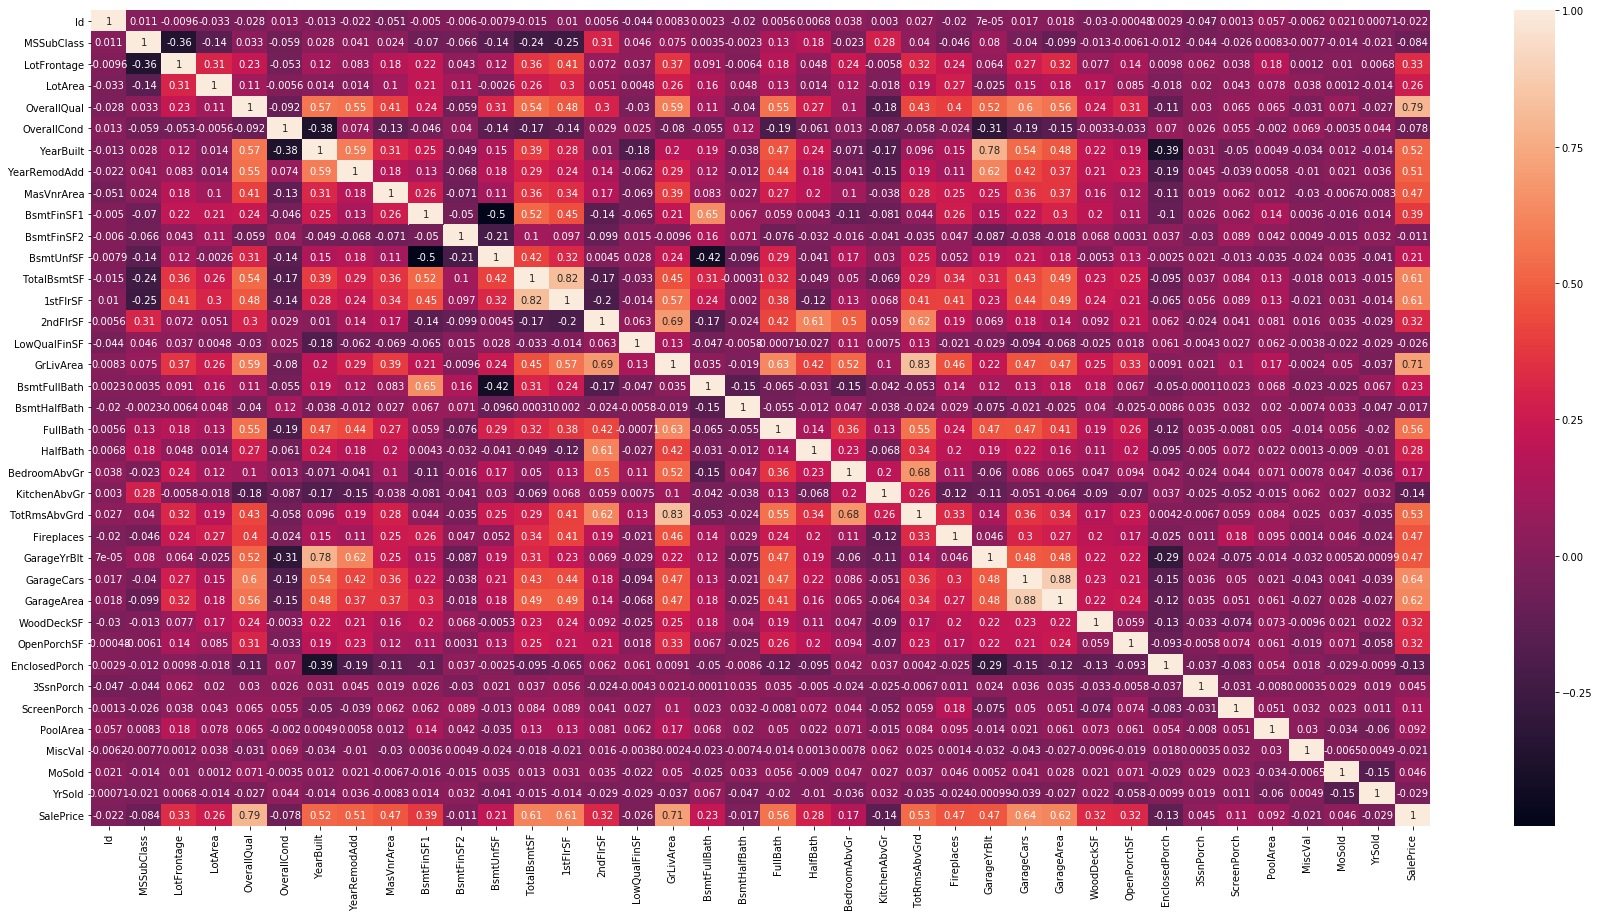

In [14]:
plt.figure(figsize=[30,15])
sns.heatmap(train.corr(), annot=True)

In [15]:
#from 2 features high correlated, removing the less correlated with SalePrice
train.drop(['GarageArea','1stFlrSF','TotRmsAbvGrd','2ndFlrSF','BsmtFullBath'], axis=1, inplace=True)
test.drop(['GarageArea','1stFlrSF','TotRmsAbvGrd','2ndFlrSF','BsmtFullBath'], axis=1, inplace=True)


In [16]:
#removing outliers recomended by author in the problem description page...
train = train[train['GrLivArea']<4000]

In [17]:
houses=pd.concat([train,test], sort=False)

## Data Tranformations
### Numerical to Categorical

In [18]:
houses['MSSubClass'] = houses['MSSubClass'].astype(str)

In [19]:
len_train=train.shape[0]
print(train.shape)

(1456, 76)


In [20]:
skew=houses.select_dtypes(include=['int','float']).apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skew_df=pd.DataFrame({'Skew':skew})
skewed_df=skew_df[(skew_df['Skew']>0.5)|(skew_df['Skew']<-0.5)]

In [21]:
skewed_df.index

Index([u'BsmtFinSF2', u'BsmtHalfBath', u'MasVnrArea', u'SalePrice',
       u'LotFrontage', u'BsmtFinSF1', u'BsmtUnfSF', u'TotalBsmtSF'],
      dtype='object')

### Categorical to one Hot-Encoding

In [22]:
houses=pd.concat([train,test], sort=False)
houses=pd.get_dummies(houses)

## Brewing and getting things ready for the model!

In [23]:
train=houses[:len_train]
test=houses[len_train:]

In [25]:
lam=0.1
for col in ('MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
       'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch',
       'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF',
       'LotFrontage', 'GrLivArea', 'BsmtFinSF1', 'BsmtUnfSF', 'Fireplaces',
       'HalfBath', 'TotalBsmtSF', 'OverallCond', 'YearBuilt',
       'GarageYrBlt'):
    train[col]=boxcox1p(train[col],lam)
    test[col]=boxcox1p(test[col],lam)

C:\Users\shekh\Anaconda2\envs\gl-env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\shekh\Anaconda2\envs\gl-env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [26]:
train['SalePrice']=np.log(train['SalePrice'])

C:\Users\shekh\Anaconda2\envs\gl-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [27]:
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

C:\Users\shekh\Anaconda2\envs\gl-env\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## sKew

In [28]:
x=train.drop('SalePrice', axis=1)
y=train['SalePrice']
test=test.drop('SalePrice', axis=1)

In [29]:
sc=RobustScaler()
x=sc.fit_transform(x)
test=sc.transform(test)


In [30]:
model=Lasso(alpha =0.001, random_state=1)

In [31]:
model.fit(x,y)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)

In [32]:
pred=model.predict(test)
preds=np.exp(pred)

In [33]:
output=pd.DataFrame({'Id':test2.Id, 'SalePrice':preds})
output.to_csv('submission.csv', index=False)

In [34]:
output.head()

,Id,SalePrice
0,1461,118836.036050
1,1462,153798.156133
2,1463,183337.542998
3,1464,200614.380236
4,1465,196583.043456
